# Analysis of the Temporal Evolution of Loads by Balancing Authority

This notebook analyzes the time series of annual total and peak loads from TELL by Balancing Authority (BA).

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/figures/Balancing_Authorities/'


## Process the TELL Output Files

In [3]:
# Check to see if the processed output file exist and if not then create it:
if os.path.isfile((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv'))) == False:

   # Set the scenarios to process:
   scenarios = ['historic', 'rcp45cooler_ssp3', 'rcp45cooler_ssp5', 'rcp45hotter_ssp3', 'rcp45hotter_ssp5', 'rcp85cooler_ssp3', 'rcp85cooler_ssp5', 'rcp85hotter_ssp3', 'rcp85hotter_ssp5']
      
   #Initiate a counter and empty dataframe to store the results:
   counter = 0;
   output_df = pd.DataFrame()

   # Loop over the scenarios and process each time series:
   for s in range(len(scenarios)):
       if scenarios[s] == 'historic':
          start_year = 1980; end_year = 2020; interval = 1
       else:
          start_year = 2020; end_year = 2100; interval = 5
        
       # Loop over the years from the start_year to the end_year in 5-year increments:
       for year in range(start_year,end_year,interval):
           # Read in the TELL BA output file for that year and scenario:
           tell_df = pd.read_csv(data_input_dir + 'outputs/tell_output/' + scenarios[s] + '/' + str(year) + '/TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
             
           # Make a list of all of the BAs in the 'tell_df':
           bas = tell_df['BA_Code'].unique()
         
           # Loop over the BAs and calculate the total and peak load for each year:
           for i in range(len(bas)):
               # Iterate the counter by one:
               counter = counter + 1
            
               # Subset to just the data for the BA being processed:
               subset_df = tell_df[tell_df['BA_Code'].isin([bas[i]])].copy()
          
               # Put the output in a new dataframe:
               output_df.loc[counter, 'Scenario'] = scenarios[s]
               output_df.loc[counter, 'Year'] = int(year)
               output_df.loc[counter, 'BA'] = bas[i]
               output_df.loc[counter, 'Total_Load_TWh'] = (subset_df['Scaled_TELL_BA_Load_MWh'].sum().round(6)) / 1000000
               output_df.loc[counter, 'Peak_Load_MWh'] = subset_df['Scaled_TELL_BA_Load_MWh'].max()
            
               # Clean up
               del subset_df

           # Clean up
           del tell_df, bas
         
   # Initiate an empty normalized load variable:
   output_df['Total_Load_Normalized'] = np.nan
   output_df['Peak_Load_Normalized'] = np.nan

   # Loop over the rows of the dataframe normalize the load by the base year value:
   for row in range(len(output_df)):
       # Find the total load value to normalize by:
       base_load = output_df['Total_Load_TWh'].loc[(output_df['Year'] == 2019) & 
                                                   (output_df['BA'] == output_df['BA'].iloc[row]) & 
                                                   (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized total load:
       output_df['Total_Load_Normalized'].iloc[row] = (output_df['Total_Load_TWh'].iloc[row] / base_load).round(3)
    
       # Find the peak load value to normalize by:
       peak_load = output_df['Peak_Load_MWh'].loc[(output_df['Year'] == 2019) & 
                                                  (output_df['BA'] == output_df['BA'].iloc[row]) & 
                                                  (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized peak load:
       output_df['Peak_Load_Normalized'].iloc[row] = (output_df['Peak_Load_MWh'].iloc[row] / peak_load).round(3)
    
       # Clean up
       del base_load, peak_load

   # Write out the dataframe to a .csv file:
   output_df.to_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')), sep=',', index=False)
   
else:
   # Read in the already processed output file:
   output_df = pd.read_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')))            
                  
# Preview the future dataframe:
output_df


,Scenario,Year,BA,Total_Load_TWh,Peak_Load_MWh,Total_Load_Normalized,Peak_Load_Normalized
0,historic,1980.0,AEC,1.545518,384.66,0.322,0.375
1,historic,1980.0,AECI,6.810830,1549.42,0.319,0.285
2,historic,1980.0,AVA,6.099248,1227.54,0.463,0.504
3,historic,1980.0,AZPS,7.448840,1783.57,0.225,0.227
4,historic,1980.0,BANC,6.589488,1684.58,0.355,0.382
...,...,...,...,...,...,...,...
9067,rcp85hotter_ssp5,2095.0,TPWR,12.303224,1992.09,2.268,2.072
9068,rcp85hotter_ssp5,2095.0,TVA,404.389748,84363.37,2.362,2.582
9069,rcp85hotter_ssp5,2095.0,WACM,77.710548,13849.97,2.807,3.248
9070,rcp85hotter_ssp5,2095.0,WALC,27.318602,5164.14,2.817,2.982


In [4]:
# Define a function to plot the time series of annual demand for each BA:
def plot_ba_load_time_series(ba_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')))
    ba_df = output_df[output_df['BA'] == ba_to_plot]
    
    # Subset to the time series for each scenario:
    ba_historic = ba_df[ba_df['Scenario'].isin(['historic'])]
    ba_rcp45cooler_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp45cooler_ssp3'])]
    ba_rcp45cooler_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp45cooler_ssp5'])]
    ba_rcp45hotter_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp45hotter_ssp3'])]
    ba_rcp45hotter_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp45hotter_ssp5'])]
    ba_rcp85cooler_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp85cooler_ssp3'])]
    ba_rcp85cooler_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp85cooler_ssp5'])]
    ba_rcp85hotter_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp85hotter_ssp3'])]
    ba_rcp85hotter_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp85hotter_ssp5'])]
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(221)
    plt.plot(ba_historic['Year'], ba_historic['Total_Load_TWh'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp3['Year'], ba_rcp45cooler_ssp3['Total_Load_TWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp5['Year'], ba_rcp45cooler_ssp5['Total_Load_TWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp3['Year'], ba_rcp45hotter_ssp3['Total_Load_TWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp5['Year'], ba_rcp45hotter_ssp5['Total_Load_TWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp3['Year'], ba_rcp85cooler_ssp3['Total_Load_TWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp5['Year'], ba_rcp85cooler_ssp5['Total_Load_TWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp3['Year'], ba_rcp85hotter_ssp3['Total_Load_TWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp5['Year'], ba_rcp85hotter_ssp5['Total_Load_TWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title((ba_to_plot + ' Total Load Projections'))
    plt.title('a)', loc='left', fontsize=16)
    
    plt.subplot(222)
    plt.plot(ba_historic['Year'], ba_historic['Total_Load_Normalized'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp3['Year'], ba_rcp45cooler_ssp3['Total_Load_Normalized'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp5['Year'], ba_rcp45cooler_ssp5['Total_Load_Normalized'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp3['Year'], ba_rcp45hotter_ssp3['Total_Load_Normalized'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp5['Year'], ba_rcp45hotter_ssp5['Total_Load_Normalized'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp3['Year'], ba_rcp85cooler_ssp3['Total_Load_Normalized'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp5['Year'], ba_rcp85cooler_ssp5['Total_Load_Normalized'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp3['Year'], ba_rcp85hotter_ssp3['Total_Load_Normalized'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp5['Year'], ba_rcp85hotter_ssp5['Total_Load_Normalized'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.ylim([0, 3.5])
    plt.ylabel('Annual Total Load Normalized to 2019')
    plt.grid(True)
    plt.title((ba_to_plot + ' Total Load Projections Normalized'))
    plt.title('b)', loc='left', fontsize=16)
    
    plt.subplot(223)
    plt.plot(ba_historic['Year'], ba_historic['Peak_Load_MWh']*0.001, color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp3['Year'], ba_rcp45cooler_ssp3['Peak_Load_MWh']*0.001, color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp5['Year'], ba_rcp45cooler_ssp5['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp3['Year'], ba_rcp45hotter_ssp3['Peak_Load_MWh']*0.001, color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp5['Year'], ba_rcp45hotter_ssp5['Peak_Load_MWh']*0.001, color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp3['Year'], ba_rcp85cooler_ssp3['Peak_Load_MWh']*0.001, color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp5['Year'], ba_rcp85cooler_ssp5['Peak_Load_MWh']*0.001, color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp3['Year'], ba_rcp85hotter_ssp3['Peak_Load_MWh']*0.001, color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp5['Year'], ba_rcp85hotter_ssp5['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title((ba_to_plot + ' Peak Demand Projections'))
    plt.title('c)', loc='left', fontsize=16)
    
    plt.subplot(224)
    plt.plot(ba_historic['Year'], ba_historic['Peak_Load_Normalized'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp3['Year'], ba_rcp45cooler_ssp3['Peak_Load_Normalized'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp5['Year'], ba_rcp45cooler_ssp5['Peak_Load_Normalized'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp3['Year'], ba_rcp45hotter_ssp3['Peak_Load_Normalized'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp5['Year'], ba_rcp45hotter_ssp5['Peak_Load_Normalized'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp3['Year'], ba_rcp85cooler_ssp3['Peak_Load_Normalized'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp5['Year'], ba_rcp85cooler_ssp5['Peak_Load_Normalized'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp3['Year'], ba_rcp85hotter_ssp3['Peak_Load_Normalized'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp5['Year'], ba_rcp85hotter_ssp5['Peak_Load_Normalized'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.ylim([0, 3.5])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand Normalized to 2019')
    plt.grid(True)
    plt.title((ba_to_plot + ' Peak Demand Projections Normalized'))
    plt.title('d)', loc='left', fontsize=16)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('BA_Load_Projections_' + ba_to_plot.replace(" ", "_") + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
       plt.close()
    

In [5]:
# Make a list of all of the BAs in the 'output_df' created above:
bas = output_df['BA'].unique()
         
# Loop over the BAs and make the plot for each BA:
for i in range(len(bas)):
    plot_ba_load_time_series(ba_to_plot = bas[i],
                             data_input_dir = data_output_dir, 
                             image_output_dir = image_output_dir, 
                             image_resolution = 50, 
                             save_images = True)


In [12]:
# Define a function to plot the distribution of load changes across BAs:
def plot_ba_load_box_plots(data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')))
    output_df = output_df.loc[output_df['Scenario'] != 'historic']

    # Set the style parameters for the box plots:
    boxprops1=dict(color='blue',   linestyle='--', linewidth=2); medianprops1=dict(color='blue',   linewidth=2); whiskerprops1=dict(color='blue',   linewidth=2, linestyle='--'); flierprops1=dict(color='blue',   markeredgecolor='blue');   capprops1=dict(color='blue',   linewidth=0);
    boxprops2=dict(color='blue',   linestyle='-',  linewidth=2); medianprops2=dict(color='blue',   linewidth=2); whiskerprops2=dict(color='blue',   linewidth=2, linestyle='-');  flierprops2=dict(color='blue',   markeredgecolor='blue');   capprops2=dict(color='blue',   linewidth=0);
    boxprops3=dict(color='cyan',   linestyle='--', linewidth=2); medianprops3=dict(color='cyan',   linewidth=2); whiskerprops3=dict(color='cyan',   linewidth=2, linestyle='--'); flierprops3=dict(color='cyan',   markeredgecolor='cyan');   capprops3=dict(color='cyan',   linewidth=0);
    boxprops4=dict(color='cyan',   linestyle='-',  linewidth=2); medianprops4=dict(color='cyan',   linewidth=2); whiskerprops4=dict(color='cyan',   linewidth=2, linestyle='-');  flierprops4=dict(color='cyan',   markeredgecolor='cyan');   capprops4=dict(color='cyan',   linewidth=0);
    boxprops5=dict(color='orange', linestyle='--', linewidth=2); medianprops5=dict(color='orange', linewidth=2); whiskerprops5=dict(color='orange', linewidth=2, linestyle='--'); flierprops5=dict(color='orange', markeredgecolor='orange'); capprops5=dict(color='orange', linewidth=0);
    boxprops6=dict(color='orange', linestyle='-',  linewidth=2); medianprops6=dict(color='orange', linewidth=2); whiskerprops6=dict(color='orange', linewidth=2, linestyle='-');  flierprops6=dict(color='orange', markeredgecolor='orange'); capprops6=dict(color='orange', linewidth=0);
    boxprops7=dict(color='red',    linestyle='--', linewidth=2); medianprops7=dict(color='red',    linewidth=2); whiskerprops7=dict(color='red',    linewidth=2, linestyle='--'); flierprops7=dict(color='red',    markeredgecolor='red');    capprops7=dict(color='red',    linewidth=0);
    boxprops8=dict(color='red',    linestyle='-',  linewidth=2); medianprops8=dict(color='red',    linewidth=2); whiskerprops8=dict(color='red',    linewidth=2, linestyle='-');  flierprops8=dict(color='red',    markeredgecolor='red');    capprops8=dict(color='red',    linewidth=0);
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 14
    
    # Plot the distribution of the change in annual total load across BAs:
    plt.subplot(211)
    plt.plot([0,0], color='blue',   linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot([0,0], color='blue',   linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot([0,0], color='cyan',   linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot([0,0], color='cyan',   linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot([0,0], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot([0,0], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot([0,0], color='red',    linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot([0,0], color='red',    linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    
    for year in range(2020,2100,10):
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp45cooler_ssp3') & (output_df['Year']==year)], vert=True, positions=[year-2.8], widths=0.8, 
                    medianprops=medianprops1, whiskerprops=whiskerprops1, flierprops=flierprops1, boxprops=boxprops1, capprops=capprops1)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp45cooler_ssp5') & (output_df['Year']==year)], vert=True, positions=[year-2.0], widths=0.8, 
                    medianprops=medianprops2, whiskerprops=whiskerprops2, flierprops=flierprops2, boxprops=boxprops2, capprops=capprops2)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp45hotter_ssp3') & (output_df['Year']==year)], vert=True, positions=[year-1.2], widths=0.8, 
                    medianprops=medianprops3, whiskerprops=whiskerprops3, flierprops=flierprops3, boxprops=boxprops3, capprops=capprops3)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp45hotter_ssp5') & (output_df['Year']==year)], vert=True, positions=[year-0.4], widths=0.8, 
                    medianprops=medianprops4, whiskerprops=whiskerprops4, flierprops=flierprops4, boxprops=boxprops4, capprops=capprops4)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp85cooler_ssp3') & (output_df['Year']==year)], vert=True, positions=[year+0.4], widths=0.8, 
                    medianprops=medianprops5, whiskerprops=whiskerprops5, flierprops=flierprops5, boxprops=boxprops5, capprops=capprops5)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp85cooler_ssp5') & (output_df['Year']==year)], vert=True, positions=[year+1.2], widths=0.8, 
                    medianprops=medianprops6, whiskerprops=whiskerprops6, flierprops=flierprops6, boxprops=boxprops6, capprops=capprops6)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp85hotter_ssp3') & (output_df['Year']==year)], vert=True, positions=[year+2.0], widths=0.8, 
                    medianprops=medianprops7, whiskerprops=whiskerprops7, flierprops=flierprops7, boxprops=boxprops7, capprops=capprops7)
        plt.boxplot(output_df['Total_Load_Normalized'].loc[(output_df['Scenario']=='rcp85hotter_ssp5') & (output_df['Year']==year)], vert=True, positions=[year+2.8], widths=0.8, 
                    medianprops=medianprops8, whiskerprops=whiskerprops8, flierprops=flierprops8, boxprops=boxprops8, capprops=capprops8)
        
    plt.legend(loc='upper left', prop={'size': 12})
    plt.xlim([2015, 2095]); plt.xticks([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090],['2020','2030','2040','2050','2060','2070','2080','2090'])
    plt.ylim([0.75, 3.5])
    plt.grid(True)
    plt.ylabel('Annual Total Load Normalized to 2019')
    plt.grid(True)
    plt.title('Distribution of Annual Total Load Changes Across Balancing Authorities')
    plt.title('a)', loc='left', fontsize=13)

    
    # Plot the distribution of the change in annual total load across BAs:
    plt.subplot(212)
    for year in range(2020,2100,10):
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp45cooler_ssp3') & (output_df['Year']==year)], vert=True, positions=[year-2.8], widths=0.8, 
                    medianprops=medianprops1, whiskerprops=whiskerprops1, flierprops=flierprops1, boxprops=boxprops1, capprops=capprops1)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp45cooler_ssp5') & (output_df['Year']==year)], vert=True, positions=[year-2.0], widths=0.8, 
                    medianprops=medianprops2, whiskerprops=whiskerprops2, flierprops=flierprops2, boxprops=boxprops2, capprops=capprops2)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp45hotter_ssp3') & (output_df['Year']==year)], vert=True, positions=[year-1.2], widths=0.8, 
                    medianprops=medianprops3, whiskerprops=whiskerprops3, flierprops=flierprops3, boxprops=boxprops3, capprops=capprops3)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp45hotter_ssp5') & (output_df['Year']==year)], vert=True, positions=[year-0.4], widths=0.8, 
                    medianprops=medianprops4, whiskerprops=whiskerprops4, flierprops=flierprops4, boxprops=boxprops4, capprops=capprops4)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp85cooler_ssp3') & (output_df['Year']==year)], vert=True, positions=[year+0.4], widths=0.8, 
                    medianprops=medianprops5, whiskerprops=whiskerprops5, flierprops=flierprops5, boxprops=boxprops5, capprops=capprops5)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp85cooler_ssp5') & (output_df['Year']==year)], vert=True, positions=[year+1.2], widths=0.8, 
                    medianprops=medianprops6, whiskerprops=whiskerprops6, flierprops=flierprops6, boxprops=boxprops6, capprops=capprops6)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp85hotter_ssp3') & (output_df['Year']==year)], vert=True, positions=[year+2.0], widths=0.8, 
                    medianprops=medianprops7, whiskerprops=whiskerprops7, flierprops=flierprops7, boxprops=boxprops7, capprops=capprops7)
        plt.boxplot(output_df['Peak_Load_Normalized'].loc[(output_df['Scenario']=='rcp85hotter_ssp5') & (output_df['Year']==year)], vert=True, positions=[year+2.8], widths=0.8, 
                    medianprops=medianprops8, whiskerprops=whiskerprops8, flierprops=flierprops8, boxprops=boxprops8, capprops=capprops8)
    plt.xlim([2015, 2095]); plt.xticks([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090],['2020','2030','2040','2050','2060','2070','2080','2090'])
    plt.ylim([0.75, 3.5])
    plt.grid(True)
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand Normalized to 2019')
    plt.grid(True)
    plt.title('Distribution of Annual Peak Demand Changes Across Balancing Authorities')
    plt.title('b)', loc='left', fontsize=13)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('BA_Load_Change_Distributions.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
           

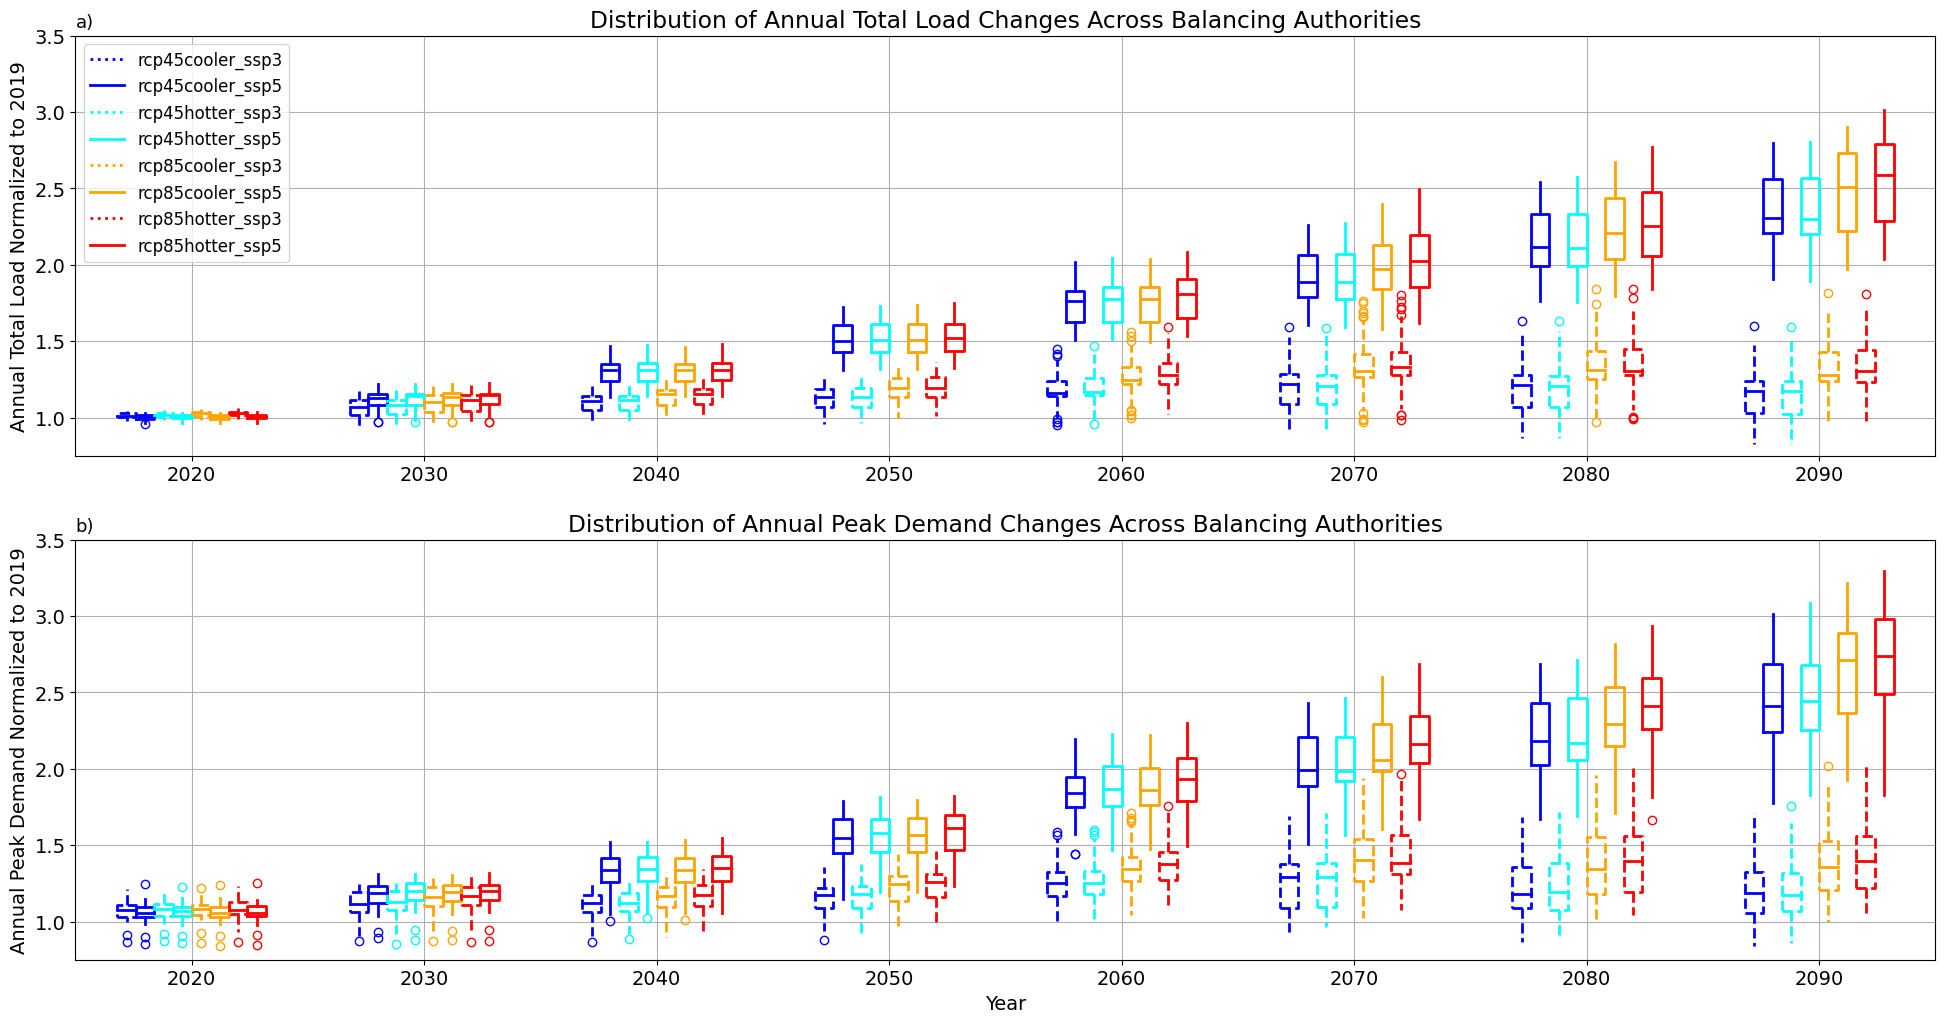

In [13]:
plot_ba_load_box_plots(data_input_dir = data_output_dir, 
                       image_output_dir = image_output_dir, 
                       image_resolution = 300, 
                       save_images = True)
